For dynamic time warping use LB Q

In [36]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os

# Constructing PAA

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Normalization

In [38]:
def Z_normalize(data):
    data = np.array(data)
    normalized_data = (data - np.mean(data)) / np.std(data)
    return normalized_data

## PAA

In [39]:
def PAA(feature_size,segment_size,feature):
  segment=feature_size//segment_size
  PAA=[]
  for i in range(segment_size):
    range_sum=0
    start=(segment*i)+1
    end=segment*(i+1)
    for j in range(start,end):
      range_sum+=feature[j-1]
    PAA.append(range_sum/segment_size)
  return PAA

### PAA Lookup Table

In [40]:
lookup_table = {3: [-.43, .43],
                4: [-.67, 0, .67],
                5: [-.84, -.25, .25, .84],
                6: [-.97, -.43, 0, .43, .97],
                7: [-1.07, -.57, -1.18, .18, .57, 1.07],
                8: [-1.15, -.67, -.32, 0, .32, .67, 1.15],
                9: [-1.22, -.76, -.43, -.14, .14, .43, .76, 1.22],
                10: [-1.28, -.84, -.52, -.25, 0, .25, .52, .84, 1.28]}

#SAX

In [41]:
def SAX(data, lookup_table, a=4):
  letters=list(string.ascii_lowercase)

  SAX_transform=[]
  for x in data:
    index=bisect.bisect(lookup_table[a],x) #Finds the right bin index
    SAX_transform.append(letters[index])

  return SAX_transform

In [42]:
def sax_bop_histogram(sample,segment_size,lookup_table,a=4,window_size=2):
  symbols=[]
  for feature in sample:
    feature=Z_normalize(feature)
    paa=PAA(len(feature),segment_size,feature)
    sax=SAX(paa,lookup_table,a)
    symbols.extend(sax)
  histogram=count_subsequences(symbols,window_size)
  return histogram

In [43]:
#@title LB_Keogh

def bounds(Q_1d, r):
    Ubound = []
    Lbound = []
    length = len(Q_1d)
    for i in range(length):
        start = max(0, i - r)
        end = min(length - 1, i + r)

        window = Q_1d[start:end + 1]
        Ubound.append(max(window))
        Lbound.append(min(window))

    return Ubound, Lbound



In [44]:
import string
import random
import bisect

In [45]:
def generate_C(length, c_range=(0, 10)):
    c = [round(random.uniform(c_range[0], c_range[1]), 2) for _ in range(length)]

    return c

In [46]:
from collections import Counter

def count_subsequences(C_hat, window_size=2):
    subsequences = [
        tuple(C_hat[i:i + window_size])
        for i in range(len(C_hat) - window_size + 1)
    ]
    return Counter(subsequences)


In [47]:
from sklearn.metrics.pairwise import euclidean_distances

In [48]:
from pickle import FALSE
#@title Helper funcitons

def vectorize_bop(histogram, vocabulary):
    return np.array([histogram.get(sym, 0) for sym in vocabulary], dtype=np.float32)

def build_bop_dataset(X, segment_size, PAA_lookup_table, window_size=2, a=4):
    histograms = [sax_bop_histogram(sample, segment_size, PAA_lookup_table, a=a,window_size=window_size) for sample in X]

    # Build global vocabulary
    all_keys = set()
    for h in histograms:
        all_keys.update(h.keys())
    vocabulary = sorted(all_keys)

    bop_vectors = np.array([vectorize_bop(h, vocabulary) for h in histograms])
    return bop_vectors, vocabulary

def classify_bop_1nn(X_train_vecs, y_train, X_test_vecs):
    predictions = []
    nn_indices = []

    distances = euclidean_distances(X_test_vecs, X_train_vecs)
    for row in distances:
        idx = np.argmin(row)
        predictions.append(y_train[idx])
        nn_indices.append(idx)

    return predictions, nn_indices

def sax_bop_train(X_train, y_train, X_test, y_test, lookup_table, segment_size=10, a=4, window_size=2,parameters=False):

    if parameters==False:
      print("Generating BOP histograms...")
    X_train_histograms = [sax_bop_histogram(sample, segment_size, lookup_table, window_size=window_size, a=a) for sample in X_train]

    # Build vocabulary from training only
    vocabulary = sorted(set().union(*[h.keys() for h in X_train_histograms]))

    # Vectorize train and test using same vocab
    X_train_vecs = np.array([vectorize_bop(h, vocabulary) for h in X_train_histograms])
    X_test_histograms = [sax_bop_histogram(sample, segment_size, lookup_table, window_size=window_size, a=a) for sample in X_test]
    X_test_vecs = np.array([vectorize_bop(h, vocabulary) for h in X_test_histograms])


    if parameters==False:
      print("Running 1NN classification...")
    y_pred, nn_indices = classify_bop_1nn(X_train_vecs, y_train, X_test_vecs)

    accuracy = sum(y_pred[i] == y_test[i] for i in range(len(y_test))) / len(y_test)
    if parameters==False:
      print(f"BOP + 1NN Accuracy: {accuracy:.2%}")

    return y_pred, nn_indices, X_train_vecs, X_test_vecs, vocabulary

In [49]:
# print("Available a values in lookup_table:", lookup_table.keys())


In [50]:
from inspect import Parameter
import string
import random
import bisect

test_a =[3,4,5,6,7,8,9,10]
test_segment=[10,15,20,25,30,35,40,45,50]
test_window=[2,3,4]

from sklearn.metrics import accuracy_score

def get_best_combination(X_train, y_train, X_test, y_test):
  test_a =[3,4,5,6,7,8,9,10]
  test_segment=[5,10,15,20,25,30,35,40,45,50]
  test_window=[2,3,4]

  best_score = 0
  best_params = {}
  Parameters=True

  for a in test_a:
    for segment in test_segment:
      for window in test_window:
        #print(f"Trying a={a}, segment={segment}, window={window}")
        # The 'a' parameter is for breakpoints, not window size
        y_pred, nn_indices, X_train_bop, X_test_bop, vocab = sax_bop_train(
          X_train, y_train, X_test, y_test,
          lookup_table=lookup_table,
          segment_size=segment, a=a, window_size=window ,parameters=Parameters # Pass 'a' to sax_bop_train
        )

        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        #print(f"Accuracy: {acc:.4f}")

        # Update best if better
        if acc > best_score:
          best_score = acc
          best_params = {'a': a, 'segment': segment, 'window': window}

    return best_score, best_params

#Data we are gonna use


In [51]:
!git clone https://github.com/ashleygomez06/HAR-DATA.git

fatal: destination path 'HAR-DATA' already exists and is not an empty directory.


In [52]:
X=torch.load('/content/HAR-DATA/X_norm.pt')
y=torch.load('/content/HAR-DATA/y_lbls.pt',weights_only=False)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

In [55]:
best_score, best_params = get_best_combination(X_train, y_train, X_test, y_test)

In [56]:
#print(f"Best Accuracy: {best_score:.4f}")
#print(f"Best Parameters: a={best_params['a']}, segment={best_params['segment']}, window={best_params['window']}")

In [57]:
y_pred, nn_indices, X_train_bop, X_test_bop, vocab =sax_bop_train(
    X_train, y_train, X_test, y_test,
    lookup_table=lookup_table,
    segment_size=best_params['segment'], a=best_params['a'], window_size=best_params['window']
)

Generating BOP histograms...
Running 1NN classification...
BOP + 1NN Accuracy: 100.00%


In [58]:
def plot_bounds_and_instance(up_bnd, low_bnd, x_trn, x_tst):
  plt.figure(figsize=(10, 6))
  plt.plot(up_bnd, color='red', label='Upper Bound')
  plt.plot(low_bnd, color='green', label='Lower Bound')
  plt.plot(x_tst, color='blue', label='C:Test Instance')
  plt.plot(x_trn, color='orange', label='Q:Train Instance')
  plt.xlabel('Time')
  plt.ylabel('Acc. m/s^2')
  plt.title('Upper and Lower Bounds and Test Instance')
  plt.legend()
  plt.grid()
  plt.show


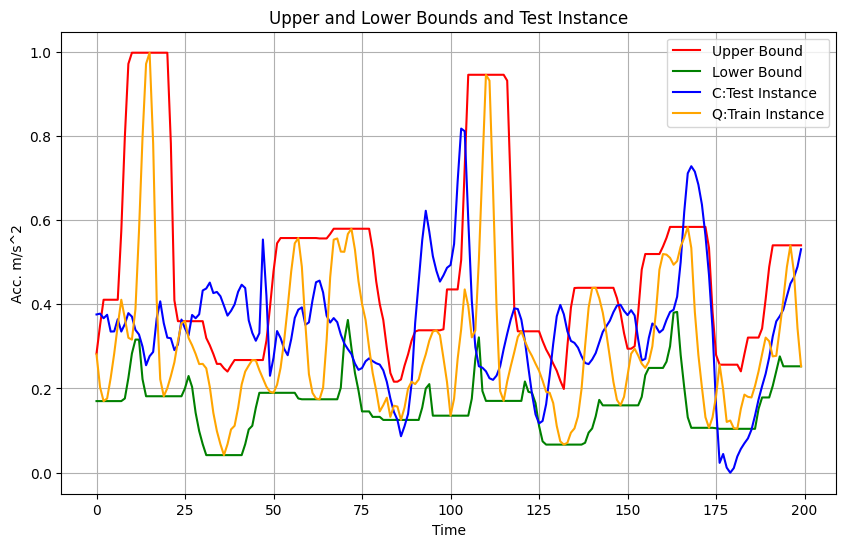

In [59]:
# Select the first test instance and its nearest neighbor from the training set
test_instance_index = 0
train_neighbor_index = nn_indices[test_instance_index]

# Get the raw time series data for the selected instances
x_tst = X_test[test_instance_index,:,:200]
x_trn = X_train[train_neighbor_index,:,:200]

# Define the radius 'r' for the bounds calculation
# You might want to choose 'r' based on the context of LB_Keogh
# For demonstration, let's use r=5 (adjust as needed)
x_trn_1d = x_trn[2]
x_tst_1d = x_tst[2]
r_value = 5

# Calculate the upper and lower bounds for the training instance (Q)
# Use the raw time series, not the BOP vectors
upper_bound, lower_bound = bounds(x_trn_1d, r_value)

# Now you can call the plotting function if needed
plot_bounds_and_instance(upper_bound, lower_bound, x_trn_1d, x_tst_1d)

# You might also want to check the shapes to ensure they are 1D arrays
# print(f"Shape of x_trn: {x_trn.shape}")
# print(f"Shape of x_tst: {x_tst.shape}")
# print(f"Shape of upper_bound: {upper_bound.shape}")
# print(f"Shape of lower_bound: {lower_bound.shape}")

In [60]:
#Visulize sax histograms


In [61]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [62]:
'''
#@title Plot 1
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

X_flat = X_all.reshape(X_all.shape[0], -1)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

n_train = len(X_train)
X_train_2D = X_tsne[:n_train]
X_test_2D = X_tsne[n_train:]

plt.figure(figsize=(10, 7))
colors = ['skyblue', 'salmon']
labels = ['Class 0', 'Class 1']

for class_val in [0, 1]:
    idx = y_train == class_val
    plt.scatter(X_train_2D[idx, 0], X_train_2D[idx, 1],
                color=colors[class_val], label=f'Train Class {class_val}',
                edgecolor='k', marker='o', s=80)

for class_val in [0, 1]:
    idx = y_test == class_val
    plt.scatter(X_test_2D[idx, 0], X_test_2D[idx, 1],
                color=colors[class_val], label=f'Test Class {class_val}',
                edgecolor='black', marker='^', s=100)

plt.title("Plot 1: Class Distribution (t-SNE on Raw Time Series)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\n#@title Plot 1\nX_all = np.concatenate((X_train, X_test), axis=0)\ny_all = np.concatenate((y_train, y_test), axis=0)\n\nX_flat = X_all.reshape(X_all.shape[0], -1)\n\ntsne = TSNE(n_components=2, perplexity=5, random_state=42)\nX_tsne = tsne.fit_transform(X_flat)\n\nn_train = len(X_train)\nX_train_2D = X_tsne[:n_train]\nX_test_2D = X_tsne[n_train:]\n\nplt.figure(figsize=(10, 7))\ncolors = [\'skyblue\', \'salmon\']\nlabels = [\'Class 0\', \'Class 1\']\n\nfor class_val in [0, 1]:\n    idx = y_train == class_val\n    plt.scatter(X_train_2D[idx, 0], X_train_2D[idx, 1],\n                color=colors[class_val], label=f\'Train Class {class_val}\',\n                edgecolor=\'k\', marker=\'o\', s=80)\n\nfor class_val in [0, 1]:\n    idx = y_test == class_val\n    plt.scatter(X_test_2D[idx, 0], X_test_2D[idx, 1],\n                color=colors[class_val], label=f\'Test Class {class_val}\',\n                edgecolor=\'black\', marker=\'^\', s=100)\n\nplt.title("Plot 1: Class Distribution (t-S

In [63]:
#@title Plot 2
'''
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)
X_flat = X_all.reshape(X_all.shape[0], -1)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

n_train = len(X_train)
X_train_2D = X_tsne[:n_train]
X_test_2D = X_tsne[n_train:]

plt.figure(figsize=(10, 7))
colors = ['skyblue', 'salmon']
labels = ['Class 0', 'Class 1']

for class_val in [0, 1]:
    idx = y_train == class_val
    plt.scatter(X_train_2D[idx, 0], X_train_2D[idx, 1],
                color=colors[class_val], label=f'Train Class {class_val}',
                edgecolor='k', marker='o', s=80)

for class_val in [0, 1]:
    idx = y_test == class_val
    plt.scatter(X_test_2D[idx, 0], X_test_2D[idx, 1],
                color=colors[class_val], label=f'Test Class {class_val}',
                edgecolor='black', marker='^', s=100)

for i, nn_idx in enumerate(nn_indices):
    test_point = X_test_2D[i]
    train_point = X_train_2D[nn_idx]

    plt.arrow(test_point[0], test_point[1],
              train_point[0] - test_point[0],
              train_point[1] - test_point[1],
              color='gray', alpha=0.6, head_width=0.6, length_includes_head=True)

plt.title("Plot 2: BOP + 1NN Matches in Raw Time Series t-SNE Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nX_all = np.concatenate((X_train, X_test), axis=0)\ny_all = np.concatenate((y_train, y_test), axis=0)\nX_flat = X_all.reshape(X_all.shape[0], -1)\n\ntsne = TSNE(n_components=2, perplexity=5, random_state=42)\nX_tsne = tsne.fit_transform(X_flat)\n\nn_train = len(X_train)\nX_train_2D = X_tsne[:n_train]\nX_test_2D = X_tsne[n_train:]\n\nplt.figure(figsize=(10, 7))\ncolors = [\'skyblue\', \'salmon\']\nlabels = [\'Class 0\', \'Class 1\']\n\nfor class_val in [0, 1]:\n    idx = y_train == class_val\n    plt.scatter(X_train_2D[idx, 0], X_train_2D[idx, 1],\n                color=colors[class_val], label=f\'Train Class {class_val}\',\n                edgecolor=\'k\', marker=\'o\', s=80)\n\nfor class_val in [0, 1]:\n    idx = y_test == class_val\n    plt.scatter(X_test_2D[idx, 0], X_test_2D[idx, 1],\n                color=colors[class_val], label=f\'Test Class {class_val}\',\n                edgecolor=\'black\', marker=\'^\', s=100)\n\nfor i, nn_idx in enumerate(nn_indices):\n    test_point = X_

In [64]:
#@title Plot 3
'''
X_bop_all = np.concatenate((X_train_bop, X_test_bop), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne_bop = tsne.fit_transform(X_bop_all)

n_train = len(X_train_bop)
X_train_bop_2D = X_tsne_bop[:n_train]
X_test_bop_2D = X_tsne_bop[n_train:]

plt.figure(figsize=(10, 7))
colors = ['skyblue', 'salmon']
labels = ['Class 0', 'Class 1']

for class_val in [0, 1]:
    idx = y_train == class_val
    plt.scatter(X_train_bop_2D[idx, 0], X_train_bop_2D[idx, 1],
                color=colors[class_val], label=f'Train Class {class_val}',
                edgecolor='k', marker='o', s=80)

for class_val in [0, 1]:
    idx = y_test == class_val
    plt.scatter(X_test_bop_2D[idx, 0], X_test_bop_2D[idx, 1],
                color=colors[class_val], label=f'Test Class {class_val}',
                edgecolor='black', marker='^', s=100)

for i, nn_idx in enumerate(nn_indices):
    test_point = X_test_bop_2D[i]
    train_point = X_train_bop_2D[nn_idx]

    plt.arrow(test_point[0], test_point[1],
              train_point[0] - test_point[0],
              train_point[1] - test_point[1],
              color='gray', alpha=0.6, head_width=0.6, length_includes_head=True)

plt.title("Plot 3: BOP Space t-SNE with 1NN Connections")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nX_bop_all = np.concatenate((X_train_bop, X_test_bop), axis=0)\ny_all = np.concatenate((y_train, y_test), axis=0)\n\ntsne = TSNE(n_components=2, perplexity=5, random_state=42)\nX_tsne_bop = tsne.fit_transform(X_bop_all)\n\nn_train = len(X_train_bop)\nX_train_bop_2D = X_tsne_bop[:n_train]\nX_test_bop_2D = X_tsne_bop[n_train:]\n\nplt.figure(figsize=(10, 7))\ncolors = [\'skyblue\', \'salmon\']\nlabels = [\'Class 0\', \'Class 1\']\n\nfor class_val in [0, 1]:\n    idx = y_train == class_val\n    plt.scatter(X_train_bop_2D[idx, 0], X_train_bop_2D[idx, 1],\n                color=colors[class_val], label=f\'Train Class {class_val}\',\n                edgecolor=\'k\', marker=\'o\', s=80)\n\nfor class_val in [0, 1]:\n    idx = y_test == class_val\n    plt.scatter(X_test_bop_2D[idx, 0], X_test_bop_2D[idx, 1],\n                color=colors[class_val], label=f\'Test Class {class_val}\',\n                edgecolor=\'black\', marker=\'^\', s=100)\n\nfor i, nn_idx in enumerate(nn_indices):\n    test